# NEWS TOPIC CLASSIFICATION

## Preliminary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/Shareddrives/Intelligent System - Assignment /Data/'

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hashlib
import math
import pickle
import re
import string
from joblib import dump, load
from time import time

import nltk
import sklearn
from tensorflow import keras

In [ ]:
# Preprocessing
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text  import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score

# Machine Learning
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Embedding, LSTM, Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Exploratory Data Analytics

In [ ]:
# data = pd.read_csv(DATA_DIR+'guardians-news/combined_filtered.csv')
data = pd.read_csv(DATA_DIR+'evnexpress/items3.csv')
data.head()

,main_class,sub_class,title,body,tag
0,news,news,Hanoi sends rhino horn trader to jail for 14 y...,"Toan, 36, made false customs declarations to a...","Vietnam,wildlife,rhino horn,conservation,envir..."
1,news,news,Vietnam Expressway Corporation officials jaile...,"A Hanoi court handed Le Quang Hao, 45, and Ngu...","Vietnam,Vietnam officials,Da Nang - Quang Ngai..."
2,news,news,HCMC plans third Covid shots starting Friday,In a draft plan regarding Covid-19 vaccination...,"Vietnam,Vietnamese,Covid-19,coronavirus,HCMC,H..."
3,news,news,HCMC metro line takes possession of six train ...,"The cars, belonging to the 8th and 9th trains ...","Vietnam,Vietnamese,HCMC,Ho Chi Minh,Saigon,tra..."
4,news,news,"Understaffed, underpaid: tough working conditi...",Thach Hung was preparing medicines for new Cov...,"Vietnam,HCMC,HCMC Covid-19,HCMC outbreak,HCMC ..."


In [ ]:
titleField = 'title'
bodyField = 'body'
bodyField = 'main_class'

In [ ]:
data.describe(include='all').loc['unique', :]

main_class       7
sub_class      707
title         3735
body          3714
tag           3534
Name: unique, dtype: object

In [ ]:
categories = data[outputField].unique()
categories

array(['news', 'business', 'world', 'travel', 'life', 'sports', 'video'],
      dtype=object)

In [ ]:
# Remove video
data = data[data[outputField]!='video']
data[outputField].replace({'world': 'news'}, inplace=True)
categories = data[outputField].unique()
categories

array(['news', 'business', 'travel', 'life', 'sports'], dtype=object)

## Word clouds and stuffs

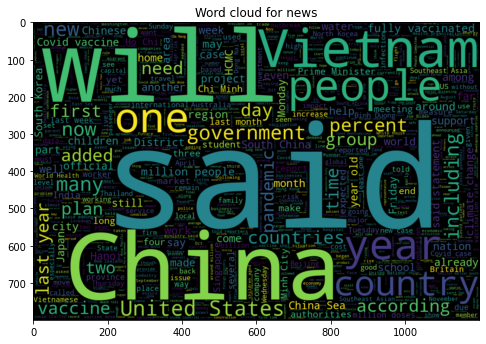

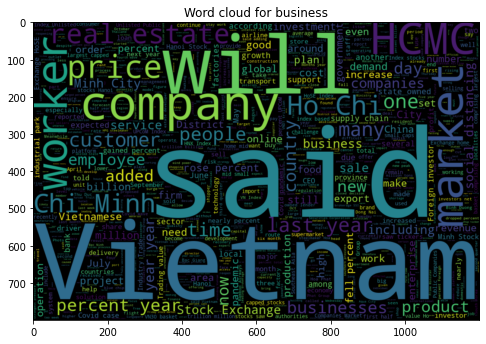

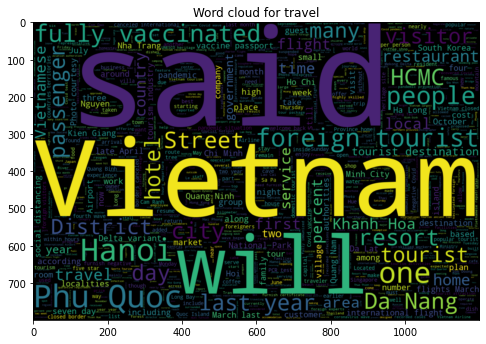

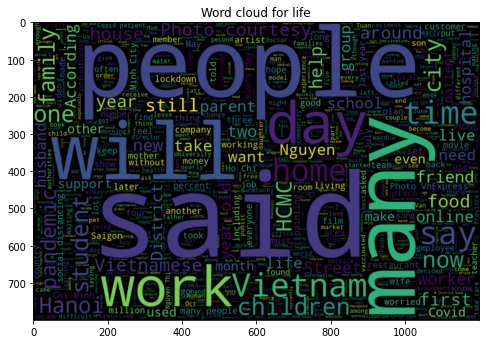

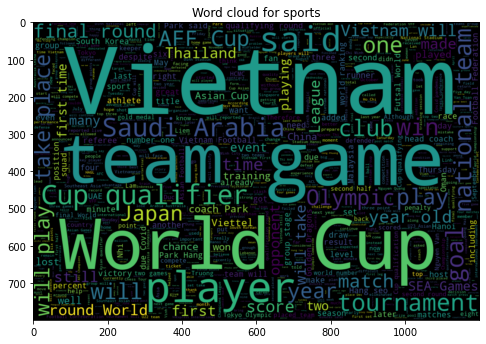

In [ ]:
from wordcloud import WordCloud

for category in categories:
  cat_desc = data[data[outputField]==category][bodyField].astype(str)
  plt.figure(figsize = (8,12))
  plt.title("Word cloud for "+category)
  wordcloud = WordCloud(min_font_size=3, max_words=1000, width=1200, height=800).generate(" ".join(cat_desc))
  plt.imshow(wordcloud,interpolation = 'bilinear')

## Data preprocessing

In [ ]:
def preprocessing(inp):
  text = str(inp)

  # Remove unicoded characters?
  text = ''.join(filter(lambda x: 32 <= ord(x) <= 128, text))

  # Tokenization and Lowercasing
  tokens = text_to_word_sequence(text, filters=string.punctuation+'\n\t', lower=True, split=" ")

  # Remove stopwords
  # tokens = list(filter(lambda t: t not in stopwords.words('english'), tokens))
  # Remove number?
  # tokens = list(filter(lambda t: t not in string.digits, tokens))

  # Stemming
  # stemmer = PorterStemmer()
  # tokens = [stemmer.stem(t) for t in tokens]

  # Lemmatization
  lemmatizer = WordNetLemmatizer()

  from collections import defaultdict
  tag_map = defaultdict(lambda : wn.NOUN)
  tag_map['J'] = wn.ADJ
  tag_map['V'] = wn.VERB
  tag_map['R'] = wn.ADV

  # tokens = [lemmatizer.lemmatize(t, tag_map[tag[0]]) for t, tag in nltk.pos_tag(tokens)]

  return ' '.join(tokens)

preprocessing(data[bodyField][0])

'toan 36 made false customs declarations to avoid checks and brought 55 pieces of rhino horns weighing 126 5 kilograms from the united arab emirates uae into vietnam in july 2019 hanoi customs officers and police detected the violation and investigated it further under vietnam s penal code the maximum jail term for holding trading and trafficking rhino horns is 15 years the education for nature vietnam env a non governmental organization said this punishment is the toughest one to date in vietnam for crimes relating to rhino horns and wildlife trade bui thi ha env vice director said amid the negative opinions about vietnams handling of wildlife crimes this heavy penalty showed that vietnams competent authorities have begun to mete out serious punishment to deter people from wildlife crimes a problem with this case is that the authorities could not detect the people who hired toan to commit the crime who are the main culprits ha said as cited by newspaper according to the env since 2017

According to https://www.kaggle.com/ishandutta/ag-news-classification-lstm/notebook, combining title and body text has better accuracy

In [ ]:
data['text'] = data[titleField] + ' ' + data[bodyField]
data['text'] = data['text'].apply(preprocessing)
data['text']

0       hanoi sends rhino horn trader to jail for 14 y...
1       vietnam expressway corporation officials jaile...
2       hcmc plans third covid shots starting friday i...
3       hcmc metro line takes possession of six train ...
4       understaffed underpaid tough working condition...
                              ...                        
5293    step change in energy investment needed to mee...
5294    india votes in penultimate phase of seven roun...
5295    myanmar plane in emergency touchdown as landin...
5296    trump to china trade deal now or it will be fa...
5297    a new climate strike opting for no children as...
Name: text, Length: 5292, dtype: object

Train-test split and TF-IDF transform

In [ ]:
LE = LabelEncoder()
data['target'] = LE.fit_transform(data[outputField])
X = data.drop(['target'], axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4233, 6), (1059, 6), (4233,), (1059,))

In [ ]:
tfidf = TfidfVectorizer(analyzer='word')
X_train_text = tfidf.fit_transform(X_train['text'])#.todense()
X_test_text = tfidf.transform(X_test['text'])#.todense()

## Training and classifying

In [ ]:
# Mapping log-probability of prediction back to probability distribution
def probability_map(log_prob):
  prob = list(map(lambda x: math.exp(x), log_prob))
  prob = np.array(prob)
  prob = prob/sum(prob)
  return prob

In [ ]:
def train_and_save(model, X_train, y_train, save_name=''):
  # Fit the model
  model.fit(X_train, y_train)
  # Save
  fn = save_name if save_name != '' else str(model)
  dump(model, fn)
  open(DATA_DIR+'../Models/'+fn, 'wb').write(pickle.dumps(model))
  return fn

In [ ]:
def load_and_test(fn, X_test, y_test):
  # Load model
  model = load(fn)
  # Predict
  pred = model.predict(X_test)
  # Evaluate accuracy and f1 metrics
  results = classification_report(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  try:
    log_probs = model.predict_proba(X_test)
  except:
    log_probs=None
  return log_probs, pred, results, accuracy

### Multinomial Naive Bayes

In [ ]:
nb_model = MultinomialNB(alpha=1.0)
nb_model

MultinomialNB()

In [ ]:
model_name = train_and_save(nb_model, X_train_text, y_train, 'multinb')
print('Saved to:', model_name)
log_probs, pred, results, accuracy = load_and_test(model_name, X_test_text, y_test)
print(results)
print("Accuracy =", accuracy)

Saved to: multinb
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       283
           1       1.00      0.08      0.15       121
           2       0.66      0.95      0.77       366
           3       0.99      0.91      0.95       208
           4       1.00      0.06      0.12        81

    accuracy                           0.78      1059
   macro avg       0.90      0.59      0.58      1059
weighted avg       0.84      0.78      0.72      1059

Accuracy = 0.777148253068933


## Misc

In [ ]:
model_list = [
  (MultinomialNB(), 'multinb'),
  # GaussianNB(), # need dense
  # (RandomForestClassifier(), 'random_forest'),
  # (DecisionTreeClassifier(), 'decision_tree'),
  (SGDClassifier(), 'sgd'),
  # (LogisticRegression(), 'logistic'),
  # (LGBMClassifier(), 'lgbm')
]

In [ ]:
for model_pair in model_list:
  st = time()
  model, name = model_pair
  model_name = train_and_save(model, X_train_text, y_train, name)
  t1 = time()-st
  st = time()
  log_probs, pred, results, accuracy = load_and_test(model_name, X_test_text, y_test)
  t2 = time()-st
  print(f"Model {model_name} \t- Accuracy {round(accuracy*100, 2)}% - Training time: {round(t1, 2)}s - Prediction time: {round(t2, 2)}s")
  

'''
Model MultinomialNB().joblib 	- Accuracy 85.09% - Training time: 0.34s - Prediction time: 0.16s
Model RandomForestClassifier().joblib 	- Accuracy 90.14% - Training time: 257.36s - Prediction time: 8.47s
Model DecisionTreeClassifier().joblib 	- Accuracy 84.57% - Training time: 246.83s - Prediction time: 0.13s
Model SGDClassifier().joblib 	- Accuracy 96.03% - Training time: 3.19s - Prediction time: 0.1s
Model LogisticRegression().joblib 	- Accuracy 95.6% - Training time: 77.78s - Prediction time: 0.18s
Model LGBMClassifier().joblib 	- Accuracy 95.07% - Training time: 1097.31s - Prediction time: 3.98s
'''

Model multinb 	- Accuracy 77.71% - Training time: 0.04s - Prediction time: 0.02s
Model sgd 	- Accuracy 96.6% - Training time: 0.35s - Prediction time: 0.04s


'\nModel MultinomialNB().joblib \t- Accuracy 85.09% - Training time: 0.34s - Prediction time: 0.16s\nModel RandomForestClassifier().joblib \t- Accuracy 90.14% - Training time: 257.36s - Prediction time: 8.47s\nModel DecisionTreeClassifier().joblib \t- Accuracy 84.57% - Training time: 246.83s - Prediction time: 0.13s\nModel SGDClassifier().joblib \t- Accuracy 96.03% - Training time: 3.19s - Prediction time: 0.1s\nModel LogisticRegression().joblib \t- Accuracy 95.6% - Training time: 77.78s - Prediction time: 0.18s\nModel LGBMClassifier().joblib \t- Accuracy 95.07% - Training time: 1097.31s - Prediction time: 3.98s\n'

## Time-series RNN (LSTM / GRU)

In [ ]:
def create_model(hidden_layers=0, dropout_rate=0.2, layer_activation='relu'):
  model = Sequential()
  # Optional: Word2Vec model (we already have TfIdf?)
  for _ in range(hidden_layers):
    model.add(Conv1D(50, 3, activation=layer_activation, padding='same', strides=1))
    model.add(MaxPool1D())
    model.add(Dropout(dropout_rate))
  model.add(Activation(layer_activation))
  model.add(Dropout(dropout_rate))
  model.add(Dense(len(categories)))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer='adam')
  return model

In [ ]:
def create_model_lstm(dropout_rate=0.2):
  model = Sequential()
  # model.add(Embedding(vocab_size, embed_size, input_length=maxlen))
  model.add(Bidirectional(LSTM(128, return_sequences=True))) 
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(GlobalMaxPool1D()) # Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
  units = 1024
  for _ in range(4):
    model.add(Dense(units))
    model.add(Dropout(dropout_rate))
    units /= 2
  model.add(Dense(len(categories)))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', # Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy'])
  return model

In [ ]:
model = create_model(hidden_layers=3)
# train
model.fit(X_train_text, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))
fn = str(model)+'.joblib'
# dump(model, fn)
# model = load(fn)
# Predict
pred = model.predict(X_test_text)
# Evaluate accuracy and f1 metrics
results = classification_report(y_test, pred)
accuracy = accuracy_score(y_test, pred)
print(results)

Epoch 1/10


ValueError: ignored

## Return output (for backend reference)



In [ ]:
def output_table(log_probs, pred, LE, X_test):
  probs = list(map(probability_map, log_probs))
  probs_t = np.transpose(probs)
  X_test['prediction'] = LE.inverse_transform(pred)
  X_test['actual'] = X_test[outputField]
  for i, category in enumerate(LE.classes_): X_test['p-'+category]=probs_t[i]
  return X_test[[titleField, bodyField, 'actual', 'prediction']+['p-'+category for category in LE.classes_]]

In [ ]:
output = output_table(log_probs, pred, LE, X_test)
output.head()

,title,body,actual,prediction,p-business,p-life,p-news,p-sports,p-travel
2156,Russia waives quarantine requirement for Vietn...,They must furnish a negative PCR test for Covi...,travel,news,0.162468,0.152588,0.373878,0.153123,0.157944
1890,Hue to open night street zone around royal cit...,"The zone would span four streets August 23, Da...",travel,news,0.189969,0.170088,0.248603,0.173546,0.217793
1893,Japanese airlines increase flights to HCMC as ...,"ANA Holdings, the parent company of All Nippon...",travel,business,0.277095,0.158924,0.243617,0.159094,0.161270
5119,Two guilty in UK over Vietnamese migrant deaths,The bodies of the men and women were found ins...,news,news,0.149006,0.148893,0.404313,0.148900,0.148887
3770,"Vietnam overcome intense playoffs, qualify for...",Vietnam could only dominate the game in the fi...,sports,sports,0.148970,0.148917,0.149103,0.404095,0.148914
